# Modeling Housing Prices on Ames IA Dataset

### Import Libraries and set Tensorflows environment

In [277]:


import os
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = "99"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib


import itertools
from sklearn.linear_model import LinearRegression, LassoLarsCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

In [278]:
# Import Data
x = pd.read_csv("data/features.csv", index_col = 0)
y = pd.read_csv("data/target.csv", index_col = 0)

### Train-Test-Split the data

In [279]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.33, random_state = 42)

In [280]:
X_train.shape

(970, 17)

### Instantiate and fit Linear Model

In [281]:
# Fit Linear Regression
lr = LinearRegression()
lr.fit(X_train, np.log(y_train))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [282]:
y_pred = lr.predict(X_test)

In [283]:
def error(actual, predicted):
    actual = np.log(actual)
    predicted = np.log(predicted)
    return np.sqrt(np.sum(np.square(actual-predicted))/len(actual))

In [284]:
error(y_test, np.exp(y_pred))

SalePrice    0.148273
dtype: float64

### Visualize Model Performance

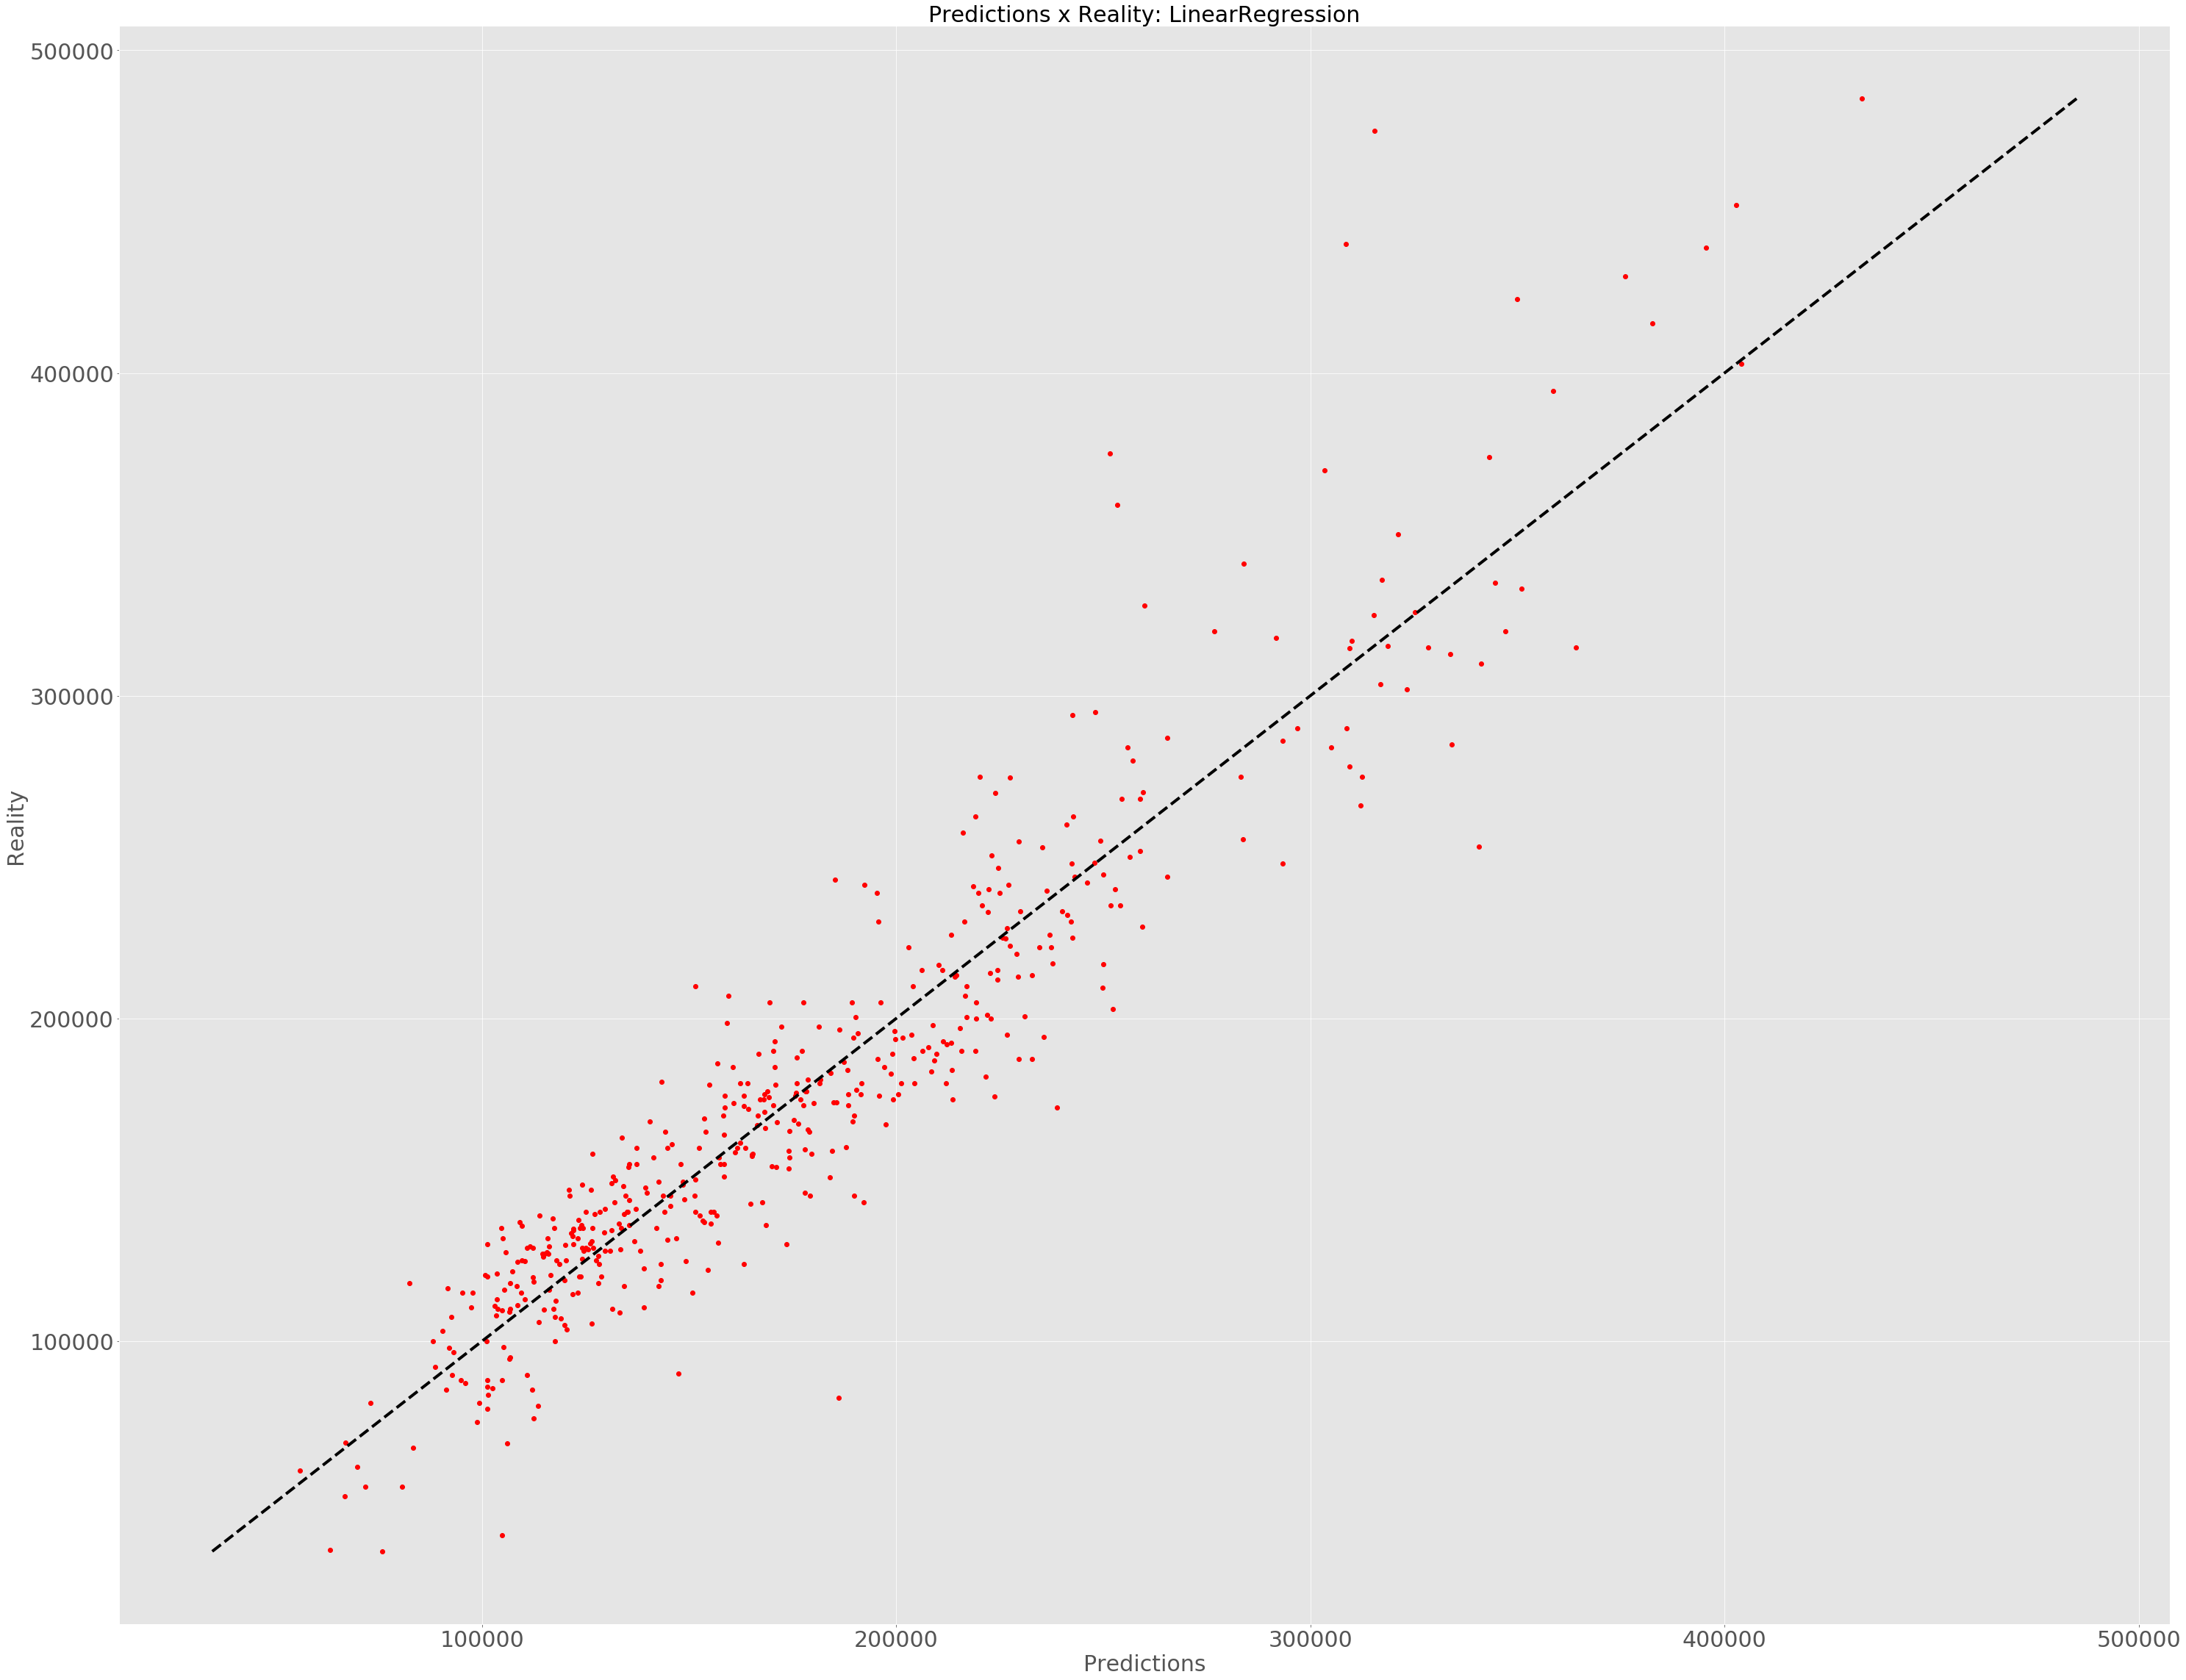

In [285]:

fig, ax = plt.subplots(figsize=(50, 40))

plt.style.use('ggplot')
plt.plot(np.exp(y_pred), y_test, 'ro')
plt.xlabel('Predictions', fontsize = 30)
plt.ylabel('Reality', fontsize = 30)
plt.title('Predictions x Reality: LinearRegression', fontsize = 30)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.show()

In [286]:
# Interpretation of Features
features_df = pd.DataFrame(lr.coef_.T, X_train.columns, columns=['Importance'])



features_df['abs'] = np.abs(features_df['Importance'])
features_df.sort_values('abs', ascending = False)

,Importance,abs
GrLivArea,0.402479,0.402479
TotalBsmtSF,-0.127412,0.127412
KitchenQual_E,0.071156,0.071156
GarageCars,0.040808,0.040808
OverallQual,0.033867,0.033867
BsmtQual_E,0.029727,0.029727
FullBath,-0.029067,0.029067
GarageFinish_E,0.026181,0.026181
TotalBsmtSF2,0.020928,0.020928
Neighborhood_E,0.013468,0.013468


### Use Tensoflows API to run DNNRegressor

In [287]:
# Import Data
x = pd.read_csv("data/features.csv", index_col = 0)
y = pd.read_csv("data/target.csv", index_col = 0)

In [288]:
# Scale our data for Tensoflows
scaler = MinMaxScaler()
x = pd.DataFrame(scaler.fit_transform(x),
                  columns = x.columns, index = x.index)
scaler_y = MinMaxScaler()
y = pd.DataFrame(scaler_y.fit_transform(y),
                 columns= y.columns, index = y.index)


In [289]:
x.head()

,OverallQual,GrLivArea,GarageCars,YearBuilt,GarageArea,FullBath,TotalBsmtSF,ExterQual_E,BsmtQual_E,KitchenQual_E,Neighborhood_E,GarageFinish_E,GarageType_E,Foundation_E,OverallQual2,TotalBsmtSF2,Neighborhood_E2
0,0.666667,0.686018,0.50,0.949275,0.871552,0.666667,0.836537,0.666667,0.75,0.666667,0.666667,0.666667,0.833333,1.0,0.484848,0.699794,0.461538
1,0.555556,0.558302,0.50,0.753623,0.847414,0.666667,0.884574,0.333333,0.75,0.333333,0.833333,0.666667,0.833333,0.4,0.353535,0.782471,0.705128
2,0.666667,0.704301,0.50,0.934783,0.885882,0.666667,0.845458,0.666667,0.75,0.666667,0.666667,0.666667,0.833333,1.0,0.484848,0.714799,0.461538
3,0.666667,0.687736,0.75,0.311594,0.893388,0.333333,0.821168,0.333333,0.50,0.666667,0.708333,0.333333,0.333333,0.2,0.484848,0.674317,0.517628
4,0.777778,0.791579,0.75,0.927536,0.929819,0.666667,0.872532,0.666667,0.75,0.666667,1.000000,0.666667,0.833333,1.0,0.636364,0.761313,1.000000


In [290]:
feature_names = x.columns

In [291]:
# List of features
engineered_features = []

for continuous_feature in feature_names:
    engineered_features.append(
        tf.feature_column.numeric_column(continuous_feature))

# Train and Test 
x_train, x_test, y_train, y_test = train_test_split(x ,
                                                    y, test_size=0.33, random_state=42)
y_train = pd.DataFrame(y_train, columns = ['SalePrice'])
y_test  = pd.DataFrame(y_test, columns = ['SalePrice'])

training_set = pd.DataFrame(x_train, columns = feature_names).merge(y_train, left_index = True, right_index = True)
testing_set  = pd.DataFrame(x_test, columns = feature_names).merge(y_test, left_index = True, right_index = True)




### Define our input functions and model

In [292]:
def input_fn_new(data_set, training = True):
    continuous_cols = {k: tf.constant(data_set[k].values) for k in feature_names}
    
    
    feature_cols = dict(list(continuous_cols.items()))
    
    if training == True:
        # Converts the label column into a constant Tensor.
        label = tf.constant(data_set['SalePrice'].values)

        # Returns the feature columns and the label.
        return feature_cols, label
    
    return feature_cols

# Model
regressor = tf.estimator.DNNRegressor(feature_columns = engineered_features, 
                                          activation_fn = tf.nn.relu, hidden_units=[200, 100, 50, 25, 12])

INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\zgebl\\AppData\\Local\\Temp\\tmppk6cwhq4', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\zgebl\\AppData\\Local\\Temp\\tmppk6cwhq4', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [293]:

# Deep Neural Network Regressor on our training data

regressor.train(input_fn = lambda: input_fn_new(training_set) , steps=2000)


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into C:\Users\zgebl\AppData\Local\Temp\tmppk6cwhq4\model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into C:\Users\zgebl\AppData\Local\Temp\tmppk6cwhq4\model.ckpt.


INFO:tensorflow:loss = 0.106166475, step = 0


INFO:tensorflow:loss = 0.106166475, step = 0


INFO:tensorflow:global_step/sec: 237.211


INFO:tensorflow:global_step/sec: 237.211


INFO:tensorflow:loss = 0.0363267, step = 100 (0.425 sec)


INFO:tensorflow:loss = 0.0363267, step = 100 (0.425 sec)


INFO:tensorflow:global_step/sec: 297.528


INFO:tensorflow:global_step/sec: 297.528


INFO:tensorflow:loss = 0.016243976, step = 200 (0.336 sec)


INFO:tensorflow:loss = 0.016243976, step = 200 (0.336 sec)


INFO:tensorflow:global_step/sec: 285.534


INFO:tensorflow:global_step/sec: 285.534


INFO:tensorflow:loss = 0.011401474, step = 300 (0.349 sec)


INFO:tensorflow:loss = 0.011401474, step = 300 (0.349 sec)


INFO:tensorflow:global_step/sec: 298.397


INFO:tensorflow:global_step/sec: 298.397


INFO:tensorflow:loss = 0.010464405, step = 400 (0.336 sec)


INFO:tensorflow:loss = 0.010464405, step = 400 (0.336 sec)


INFO:tensorflow:global_step/sec: 300.201


INFO:tensorflow:global_step/sec: 300.201


INFO:tensorflow:loss = 0.01019241, step = 500 (0.333 sec)


INFO:tensorflow:loss = 0.01019241, step = 500 (0.333 sec)


INFO:tensorflow:global_step/sec: 302.011


INFO:tensorflow:global_step/sec: 302.011


INFO:tensorflow:loss = 0.010006273, step = 600 (0.330 sec)


INFO:tensorflow:loss = 0.010006273, step = 600 (0.330 sec)


INFO:tensorflow:global_step/sec: 294.939


INFO:tensorflow:global_step/sec: 294.939


INFO:tensorflow:loss = 0.009834874, step = 700 (0.339 sec)


INFO:tensorflow:loss = 0.009834874, step = 700 (0.339 sec)


INFO:tensorflow:global_step/sec: 301.389


INFO:tensorflow:global_step/sec: 301.389


INFO:tensorflow:loss = 0.00966364, step = 800 (0.332 sec)


INFO:tensorflow:loss = 0.00966364, step = 800 (0.332 sec)


INFO:tensorflow:global_step/sec: 274.706


INFO:tensorflow:global_step/sec: 274.706


INFO:tensorflow:loss = 0.009493262, step = 900 (0.365 sec)


INFO:tensorflow:loss = 0.009493262, step = 900 (0.365 sec)


INFO:tensorflow:global_step/sec: 302.009


INFO:tensorflow:global_step/sec: 302.009


INFO:tensorflow:loss = 0.00932899, step = 1000 (0.331 sec)


INFO:tensorflow:loss = 0.00932899, step = 1000 (0.331 sec)


INFO:tensorflow:global_step/sec: 310.425


INFO:tensorflow:global_step/sec: 310.425


INFO:tensorflow:loss = 0.009164151, step = 1100 (0.321 sec)


INFO:tensorflow:loss = 0.009164151, step = 1100 (0.321 sec)


INFO:tensorflow:global_step/sec: 305.085


INFO:tensorflow:global_step/sec: 305.085


INFO:tensorflow:loss = 0.008999057, step = 1200 (0.329 sec)


INFO:tensorflow:loss = 0.008999057, step = 1200 (0.329 sec)


INFO:tensorflow:global_step/sec: 257.185


INFO:tensorflow:global_step/sec: 257.185


INFO:tensorflow:loss = 0.008837427, step = 1300 (0.388 sec)


INFO:tensorflow:loss = 0.008837427, step = 1300 (0.388 sec)


INFO:tensorflow:global_step/sec: 261.794


INFO:tensorflow:global_step/sec: 261.794


INFO:tensorflow:loss = 0.008668854, step = 1400 (0.382 sec)


INFO:tensorflow:loss = 0.008668854, step = 1400 (0.382 sec)


INFO:tensorflow:global_step/sec: 263.17


INFO:tensorflow:global_step/sec: 263.17


INFO:tensorflow:loss = 0.008516336, step = 1500 (0.381 sec)


INFO:tensorflow:loss = 0.008516336, step = 1500 (0.381 sec)


INFO:tensorflow:global_step/sec: 311.801


INFO:tensorflow:global_step/sec: 311.801


INFO:tensorflow:loss = 0.008372448, step = 1600 (0.320 sec)


INFO:tensorflow:loss = 0.008372448, step = 1600 (0.320 sec)


INFO:tensorflow:global_step/sec: 291.557


INFO:tensorflow:global_step/sec: 291.557


INFO:tensorflow:loss = 0.008231549, step = 1700 (0.344 sec)


INFO:tensorflow:loss = 0.008231549, step = 1700 (0.344 sec)


INFO:tensorflow:global_step/sec: 316.291


INFO:tensorflow:global_step/sec: 316.291


INFO:tensorflow:loss = 0.008095786, step = 1800 (0.316 sec)


INFO:tensorflow:loss = 0.008095786, step = 1800 (0.316 sec)


INFO:tensorflow:global_step/sec: 316.31


INFO:tensorflow:global_step/sec: 316.31


INFO:tensorflow:loss = 0.007966727, step = 1900 (0.315 sec)


INFO:tensorflow:loss = 0.007966727, step = 1900 (0.315 sec)


INFO:tensorflow:Saving checkpoints for 2000 into C:\Users\zgebl\AppData\Local\Temp\tmppk6cwhq4\model.ckpt.


INFO:tensorflow:Saving checkpoints for 2000 into C:\Users\zgebl\AppData\Local\Temp\tmppk6cwhq4\model.ckpt.


INFO:tensorflow:Loss for final step: 0.007841588.


INFO:tensorflow:Loss for final step: 0.007841588.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


In [294]:
# Evaluate our model on the testing data
ev = regressor.evaluate(input_fn=lambda: input_fn_new(testing_set, training = True), steps=1)

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-04-06T17:11:10Z


INFO:tensorflow:Starting evaluation at 2020-04-06T17:11:10Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from C:\Users\zgebl\AppData\Local\Temp\tmppk6cwhq4\model.ckpt-2000


INFO:tensorflow:Restoring parameters from C:\Users\zgebl\AppData\Local\Temp\tmppk6cwhq4\model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Evaluation [1/1]


INFO:tensorflow:Evaluation [1/1]


INFO:tensorflow:Inference Time : 0.27814s


INFO:tensorflow:Inference Time : 0.27814s


INFO:tensorflow:Finished evaluation at 2020-04-06-17:11:10


INFO:tensorflow:Finished evaluation at 2020-04-06-17:11:10


INFO:tensorflow:Saving dict for global step 2000: average_loss = 0.008599441, global_step = 2000, label/mean = 0.31787005, loss = 0.008599441, prediction/mean = 0.32268006


INFO:tensorflow:Saving dict for global step 2000: average_loss = 0.008599441, global_step = 2000, label/mean = 0.31787005, loss = 0.008599441, prediction/mean = 0.32268006


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: C:\Users\zgebl\AppData\Local\Temp\tmppk6cwhq4\model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: C:\Users\zgebl\AppData\Local\Temp\tmppk6cwhq4\model.ckpt-2000


In [295]:
# Model performance on testing data
loss_score = ev["loss"]
print("Final Loss on the testing set: {0:f}".format(loss_score))


Final Loss on the testing set: 0.008599


### Visualize Model performance

In [296]:

y = regressor.predict(input_fn=lambda: input_fn_new(testing_set))
predictions = list(itertools.islice(y, testing_set.shape[0]))

pred_values = [d['predictions'] for d in predictions]
pred_list = [d[0] for d in pred_values]
pred_df = pd.DataFrame(pred_list)



INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from C:\Users\zgebl\AppData\Local\Temp\tmppk6cwhq4\model.ckpt-2000


INFO:tensorflow:Restoring parameters from C:\Users\zgebl\AppData\Local\Temp\tmppk6cwhq4\model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


In [297]:
predictions = pd.DataFrame(scaler_y.inverse_transform(pred_df), columns=['Predictions'])
reality = pd.DataFrame(scaler_y.inverse_transform(np.array(testing_set.SalePrice).reshape(-1,1)), columns=['Reality'])

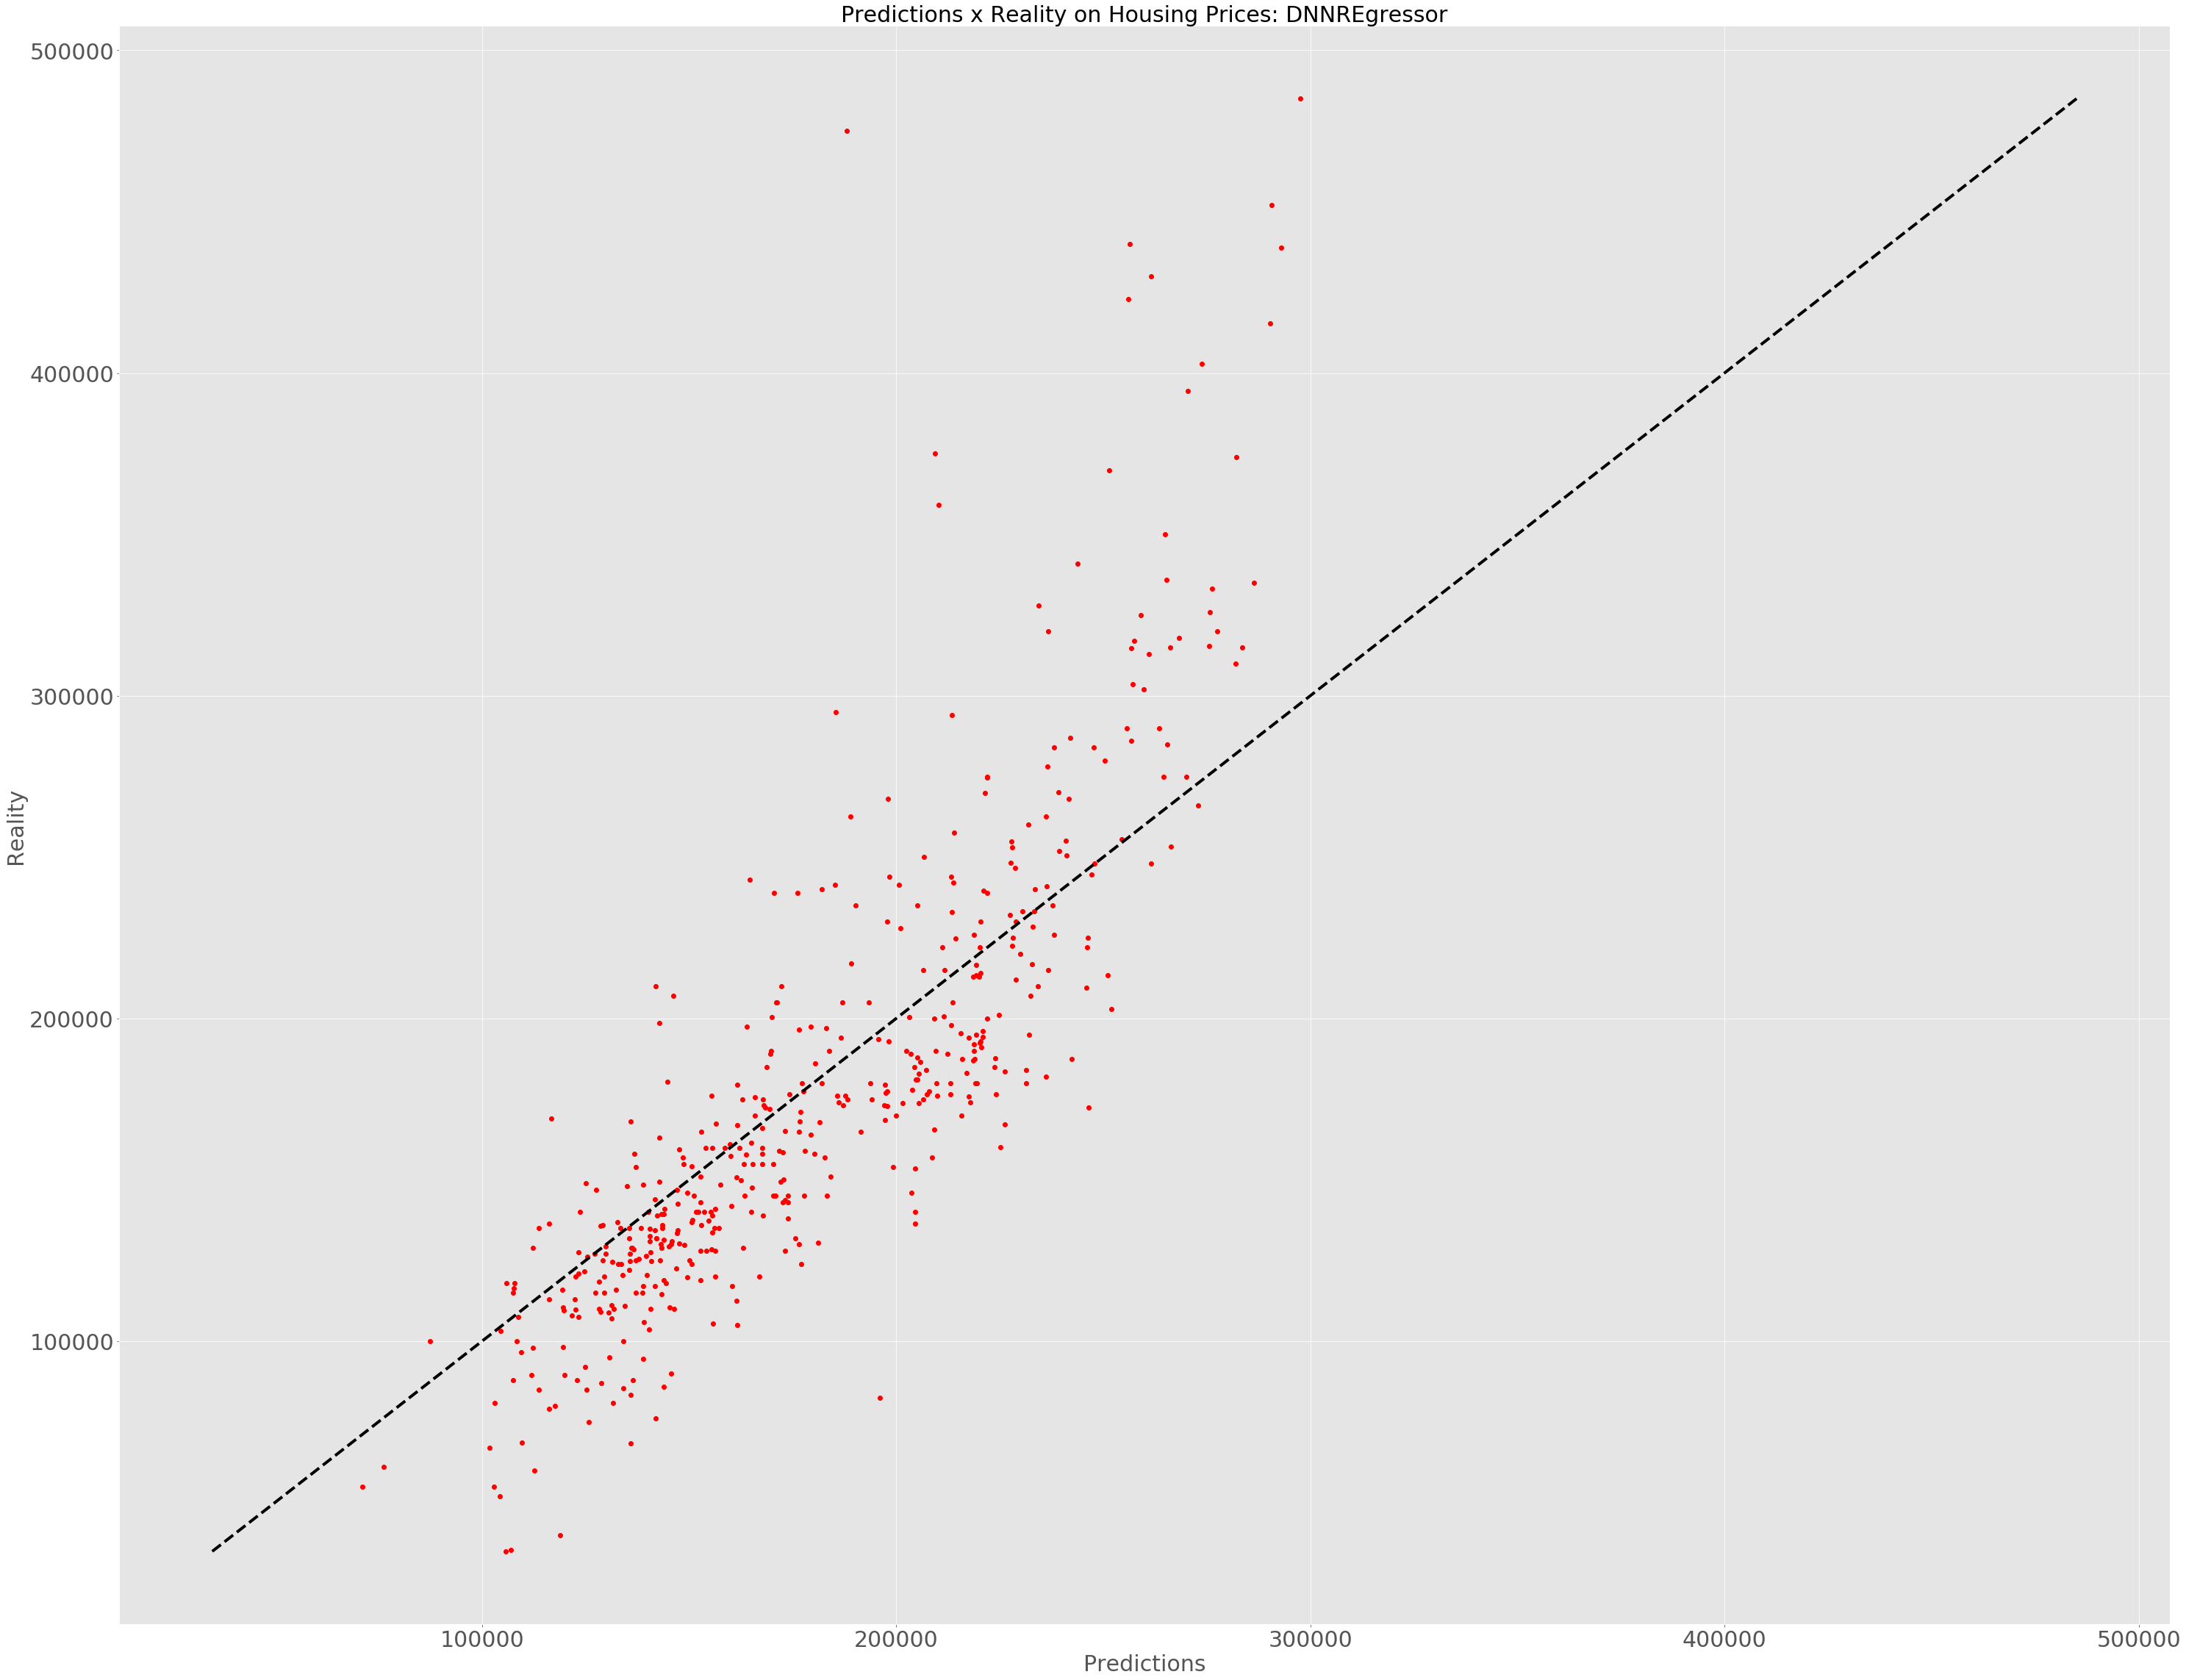

In [298]:
matplotlib.rc('xtick', labelsize=30) 
matplotlib.rc('ytick', labelsize=30) 

fig, ax = plt.subplots(figsize=(50, 40))

plt.style.use('ggplot')
plt.plot(predictions, reality, 'ro')
plt.xlabel('Predictions', fontsize = 30)
plt.ylabel('Reality', fontsize = 30)
plt.title('Predictions x Reality on Housing Prices: DNNREgressor', fontsize = 30)
ax.plot([reality.min(), reality.max()], [reality.min(), reality.max()], 'k--', lw=4)
plt.show()